In [1]:
# Change working directory
%cd ..

d:\Workplaces\Thesis\ot-kpgf


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import json
import numpy as np
import scipy
import os
import ot
import ot.plot
from optimal_transport.models import KeypointFOT, FOT, LOT, EMD
from typing import Tuple, Optional, List, Union, Dict
import copy

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rcParams['figure.dpi'] = 300

In [11]:
# Generate data and settings
samples_per_cluster = 20
def get_data(samples_per_cluster=20):
    np.random.seed(3)
    source, source_kp_idxs = [], []
    target, target_kp_idxs = [], []
    centers = [np.array([[-1,-1]]),np.array([[-3,2]]),np.array([[-2,3]]),
               np.array([[0,1]]),np.array([[-0.5,0.5]]),np.array([[-1,2]])]
    for i in range(3):
        source_kp_idxs.append(i * samples_per_cluster)
        source.append(np.concatenate(
            (centers[i],
            np.random.multivariate_normal(
                np.array([0, 0]), 
                cov=0.05 * np.array([[1, 0],[0, 1]]), 
                size=samples_per_cluster-1) + centers[i]), axis=0)
        )
        target_kp_idxs.append(i * samples_per_cluster)
        target.append(np.concatenate(
            (centers[i+3],
            np.random.multivariate_normal(
                np.array([0, 0]), 
                cov=0.05 * np.array([[1, 0], [0, 1]]), size=samples_per_cluster-1) + centers[i+3]), axis=0)
        )
    return source, target, \
           source_kp_idxs, target_kp_idxs

source, target, I, J = get_data(samples_per_cluster=samples_per_cluster)
X, Y = np.concatenate(source, axis=0), np.concatenate(target, axis=0)
a, b = np.ones(X.shape[0]) / X.shape[0], np.ones(Y.shape[0]) / Y.shape[0]
s = ["s","o","^"]
        
n_anchors = 3
n_keypoints = 3
k = 3
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.5, stop_thr=1e-5,
                               sinkhorn_reg=0.0005, temperature=0.01, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

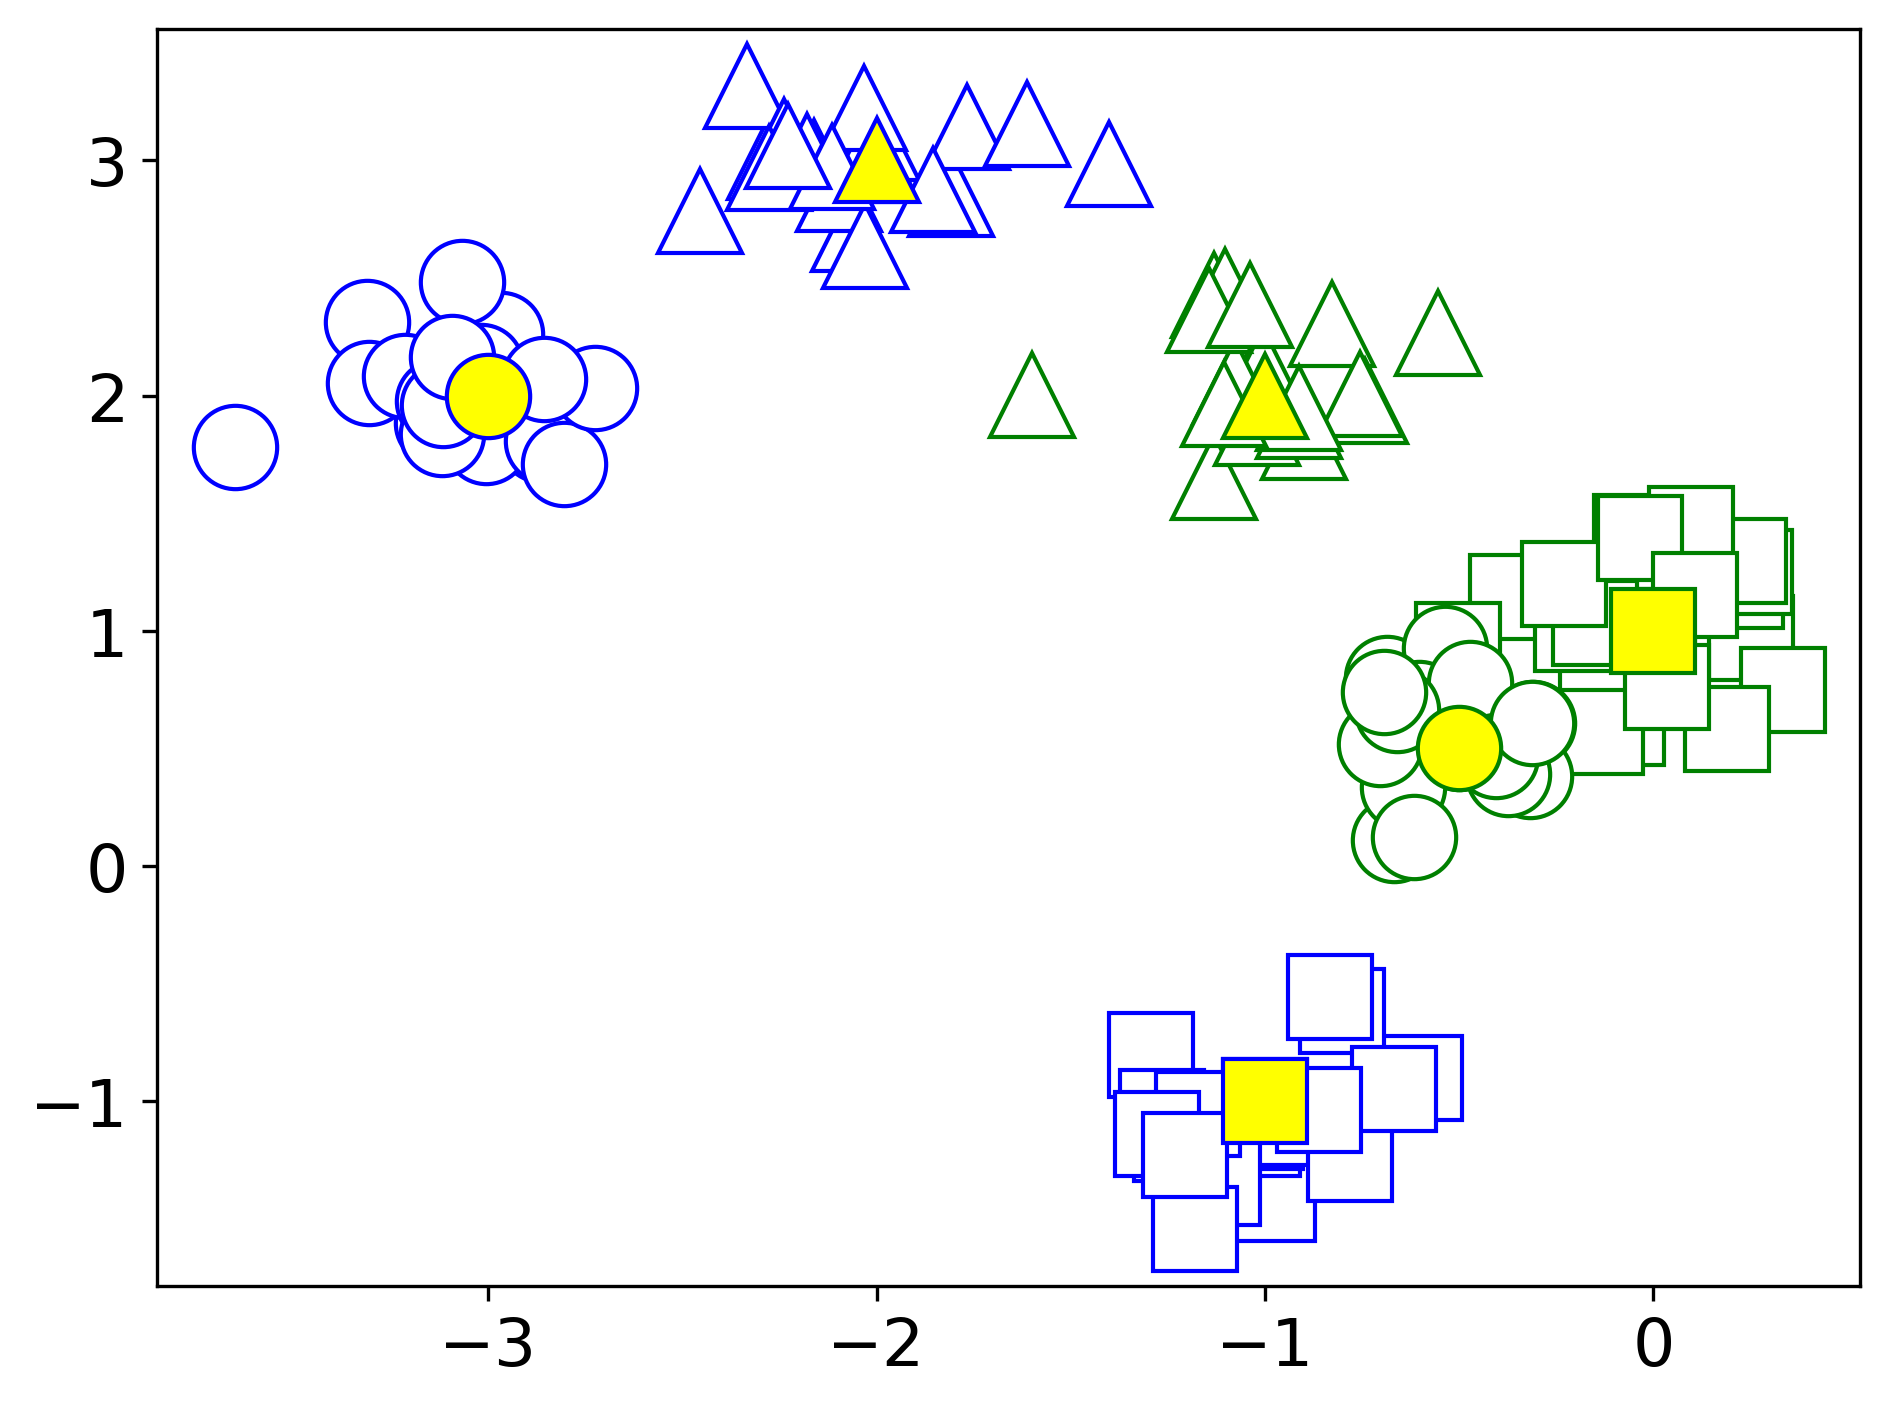

In [87]:
# plot the data
for i in range(3):
    plt.plot(source[i][:,0], source[i][:,1], 'b{}'.format(s[i]), markersize=20, markerfacecolor="white")
    plt.plot(target[i][:,0], target[i][:,1], 'g{}'.format(s[i]), markersize=20, markerfacecolor="white")

# plot keypoints
for i in range(len(I)):
    plt.plot(np.vstack(X)[I[i]][0], np.vstack(X)[I[i]][1],'b{}'.format(s[i]), markersize=20, markerfacecolor="yellow")
    plt.plot(np.vstack(Y)[J[i]][0], np.vstack(Y)[J[i]][1],'g{}'.format(s[i]), markersize=20, markerfacecolor="yellow")

plt.tight_layout()

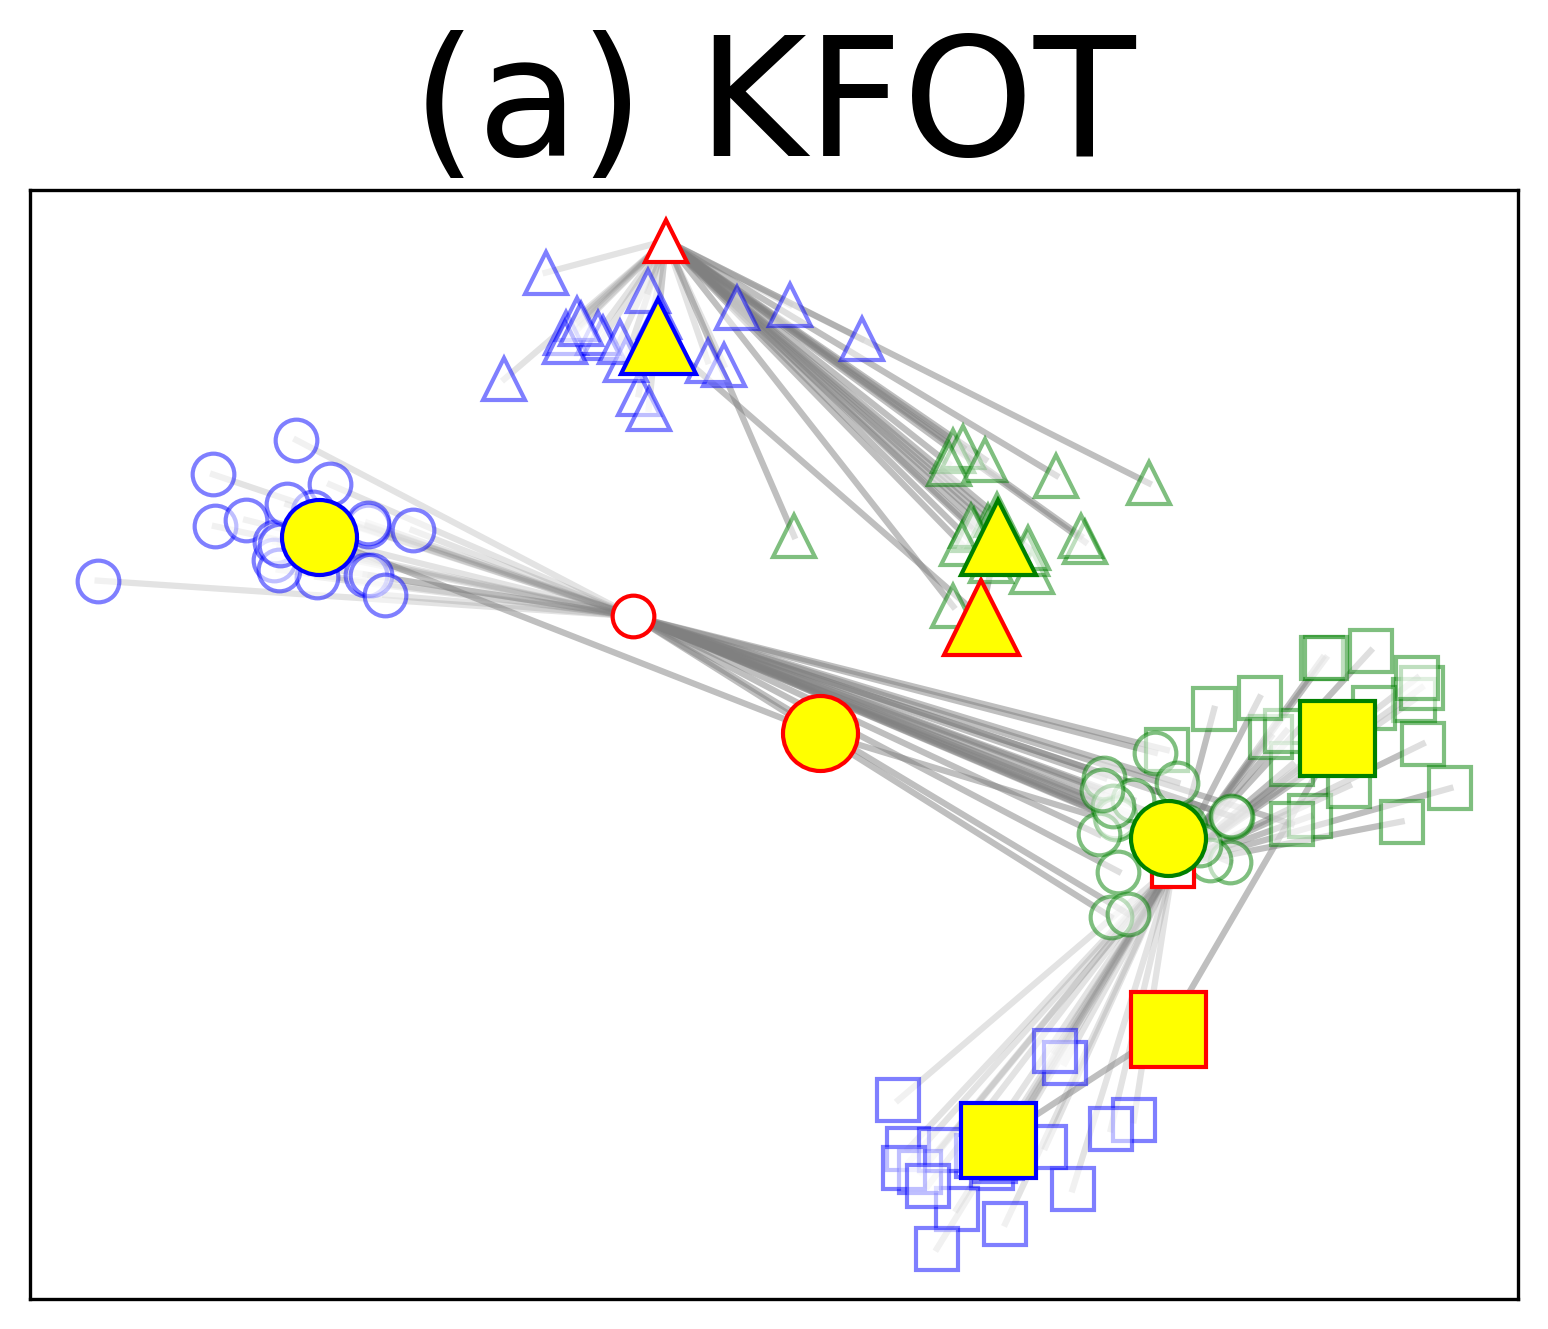

In [102]:
# KFOT
np.random.seed(1)
model: KeypointFOT = models["KeypointFOT"]
K = [(I[i], J[i]) for i in range(len(I))][:n_keypoints]
model.fit(X, Y, a, b, K=K)

# plot transport plan
ot.plot.plot2D_samples_mat(X, model.z_, np.clip(model.Pa_, 0, 0.02), c="grey", alpha=0.5)
ot.plot.plot2D_samples_mat(model.z_, Y, model.Pb_, c="grey", alpha=0.5)

# plot data
for i in range(3):
    plt.plot(source[i][:,0], source[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.5)
    plt.plot(target[i][:,0], target[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.5)

# plot anchor
j_, j__ = 0, 0
s_, s__ = [2, 0, 1], [0, 1, 2]
for i in range(n_anchors + n_keypoints):
    if i not in model.L_:
        plt.plot(model.z_[i][0], model.z_[i][1],'r{}'.format(s[s_[j_]]), markersize=10, markerfacecolor="white")
        j_ += 1
    else:
        plt.plot(model.z_[i][0], model.z_[i][1],'r{}'.format(s[s__[j__]]), markersize=18, markerfacecolor="yellow")
        j__ += 1

# plot keypoints
for i in range(len(I)):
    plt.plot(np.vstack(X)[I[i]][0], np.vstack(X)[I[i]][1],'b{}'.format(s[i]), markersize=18, markerfacecolor="yellow")
    plt.plot(np.vstack(Y)[J[i]][0], np.vstack(Y)[J[i]][1],'g{}'.format(s[i]), markersize=18, markerfacecolor="yellow")

# compute accuracy
P = model.P_
labels = [0]*samples_per_cluster + [1]*samples_per_cluster + [2]*samples_per_cluster
labels = np.array(labels)
pred = np.argmax(P, axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
#plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100), fontsize=22)

plt.tick_params(
    axis='both',       # Apply to both x and y axes
    which='both',      # Apply to both major and minor ticks
    bottom=False,      # Turn off ticks on the bottom
    top=False,         # Turn off ticks on the top
    left=False,        # Turn off ticks on the left
    right=False,       # Turn off ticks on the right
    labelbottom=False, # Turn off labels on the bottom
    labelleft=False    # Turn off labels on the left
)
plt.title(fr"(a) KFOT", fontsize=40)
plt.show()

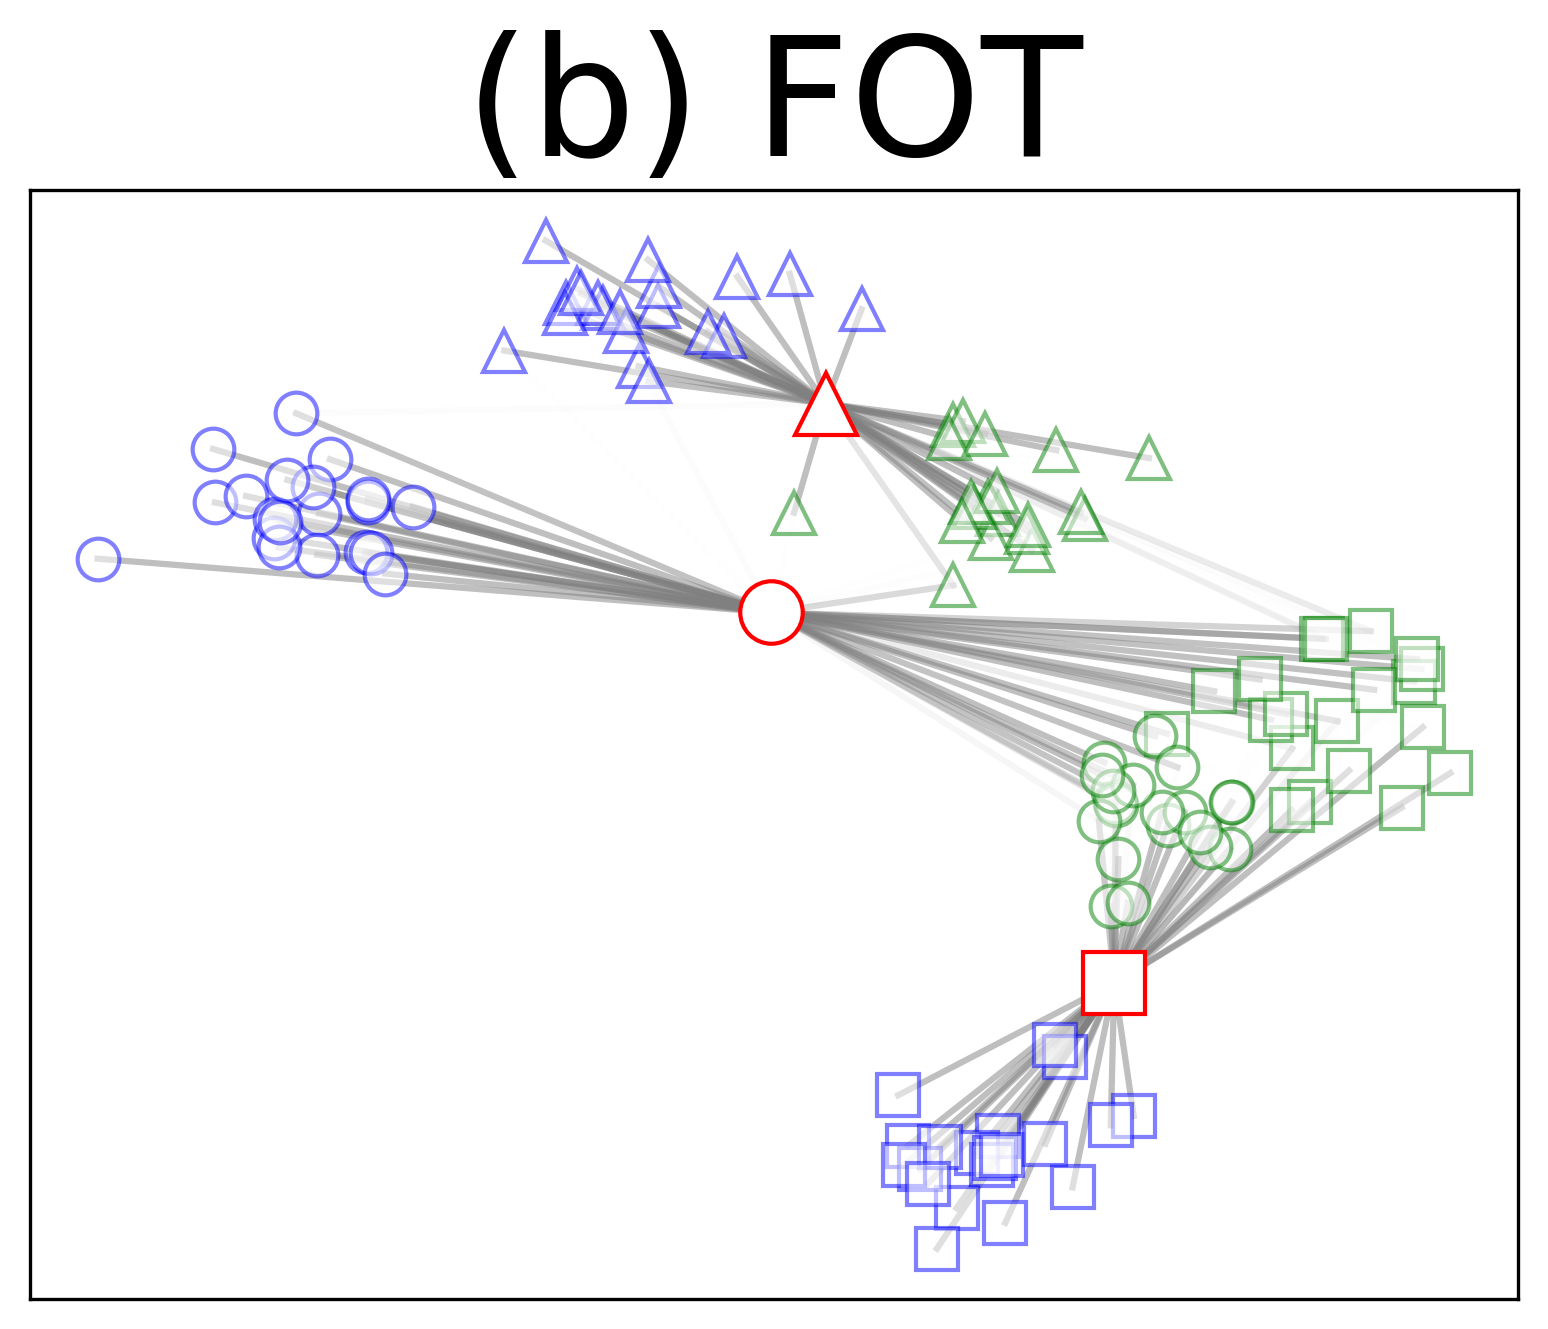

In [103]:
# FOT
np.random.seed(1)
model: FOT = models["FOT"]
model.fit(X, Y, a, b)

# plot transport plan
ot.plot.plot2D_samples_mat(X, model.z_, model.Pa_, c="grey", alpha=0.5)
ot.plot.plot2D_samples_mat(model.z_, Y, model.Pb_, c="grey", alpha=0.5)

# plot data
for i in range(3):
    plt.plot(source[i][:,0], source[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.5)
    plt.plot(target[i][:,0], target[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.5)

# plot anchor
j = 0
s_ = [1, 0, 2]
for i in range(n_anchors):
    plt.plot(model.z_[i][0], model.z_[i][1],'r{}'.format(s[s_[j]]), markersize=15, markerfacecolor="white")
    j += 1

# compute accuracy
P = model.P_
labels = [0]*samples_per_cluster + [1]*samples_per_cluster + [2]*samples_per_cluster
labels = np.array(labels)
pred = np.argmax(P, axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
#plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100), fontsize=22)

plt.tick_params(
    axis='both',       # Apply to both x and y axes
    which='both',      # Apply to both major and minor ticks
    bottom=False,      # Turn off ticks on the bottom
    top=False,         # Turn off ticks on the top
    left=False,        # Turn off ticks on the left
    right=False,       # Turn off ticks on the right
    labelbottom=False, # Turn off labels on the bottom
    labelleft=False    # Turn off labels on the left
)
plt.title(fr"(b) FOT", fontsize=40)
plt.show()

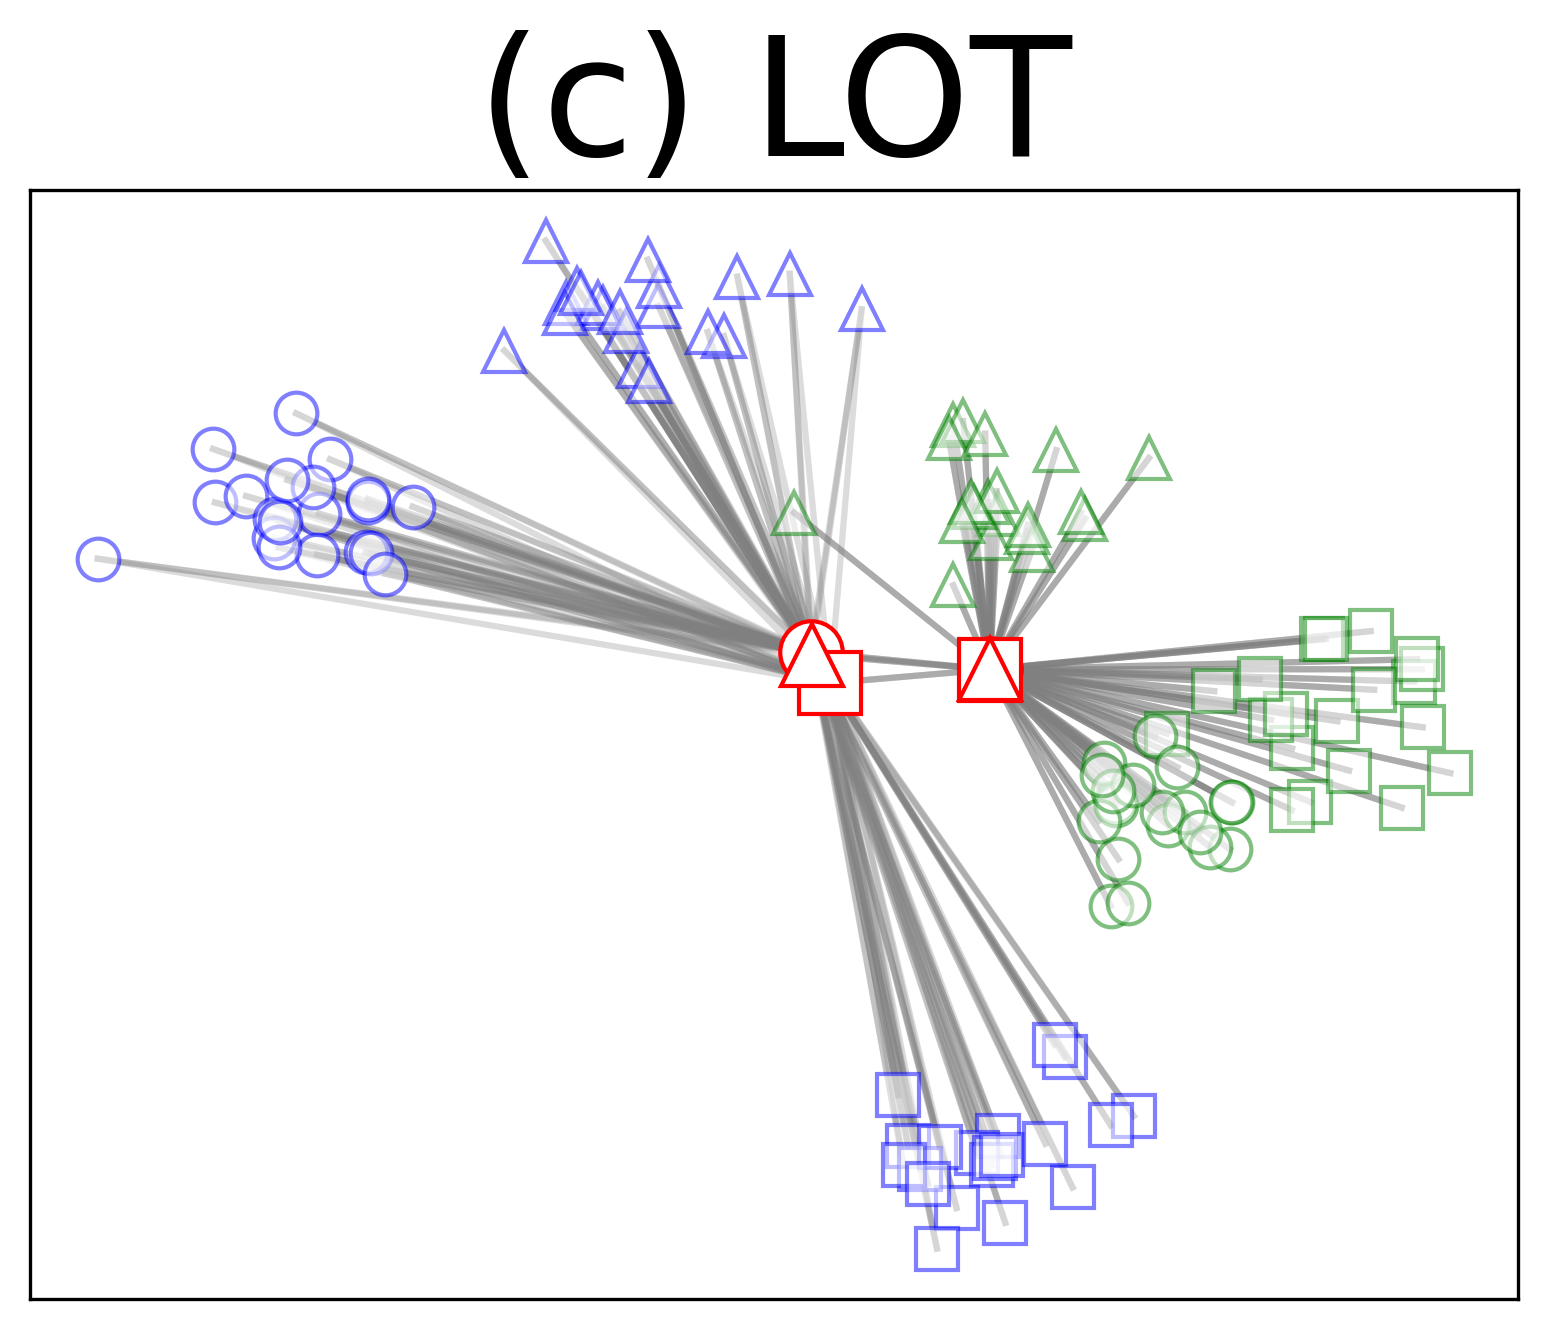

In [104]:
# LOT
np.random.seed(2)
model: LOT = models["LOT"]
model.fit(X, Y, a, b)

# plot transport plan
ot.plot.plot2D_samples_mat(X, model.Cx, model.Pa_, c="grey", alpha=0.3)
ot.plot.plot2D_samples_mat(model.Cx, model.Cy, model.Pz_, c="grey", alpha=0.3)
ot.plot.plot2D_samples_mat(model.Cy, Y, model.Pb_, c="grey", alpha=0.3)

# plot data
for i in range(3):
    plt.plot(source[i][:,0], source[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.5)
    plt.plot(target[i][:,0], target[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.5)

# plot anchor
j = 0
s_ = [1, 0, 2]
for i in range(n_anchors):
    plt.plot(model.Cx[i][0], model.Cx[i][1],'r{}'.format(s[s_[j]]), markersize=15, markerfacecolor="white")
    plt.plot(model.Cy[i][0], model.Cy[i][1],'r{}'.format(s[s_[j]]), markersize=15, markerfacecolor="white")
    j += 1

# compute accuracy
P = model.P_
labels = [0]*samples_per_cluster + [1]*samples_per_cluster + [2]*samples_per_cluster
labels = np.array(labels)
pred = np.argmax(P, axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
#plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100), fontsize=22)

plt.tick_params(
    axis='both',       # Apply to both x and y axes
    which='both',      # Apply to both major and minor ticks
    bottom=False,      # Turn off ticks on the bottom
    top=False,         # Turn off ticks on the top
    left=False,        # Turn off ticks on the left
    right=False,       # Turn off ticks on the right
    labelbottom=False, # Turn off labels on the bottom
    labelleft=False    # Turn off labels on the left
)
plt.title(fr"(c) LOT", fontsize=40)
plt.show()

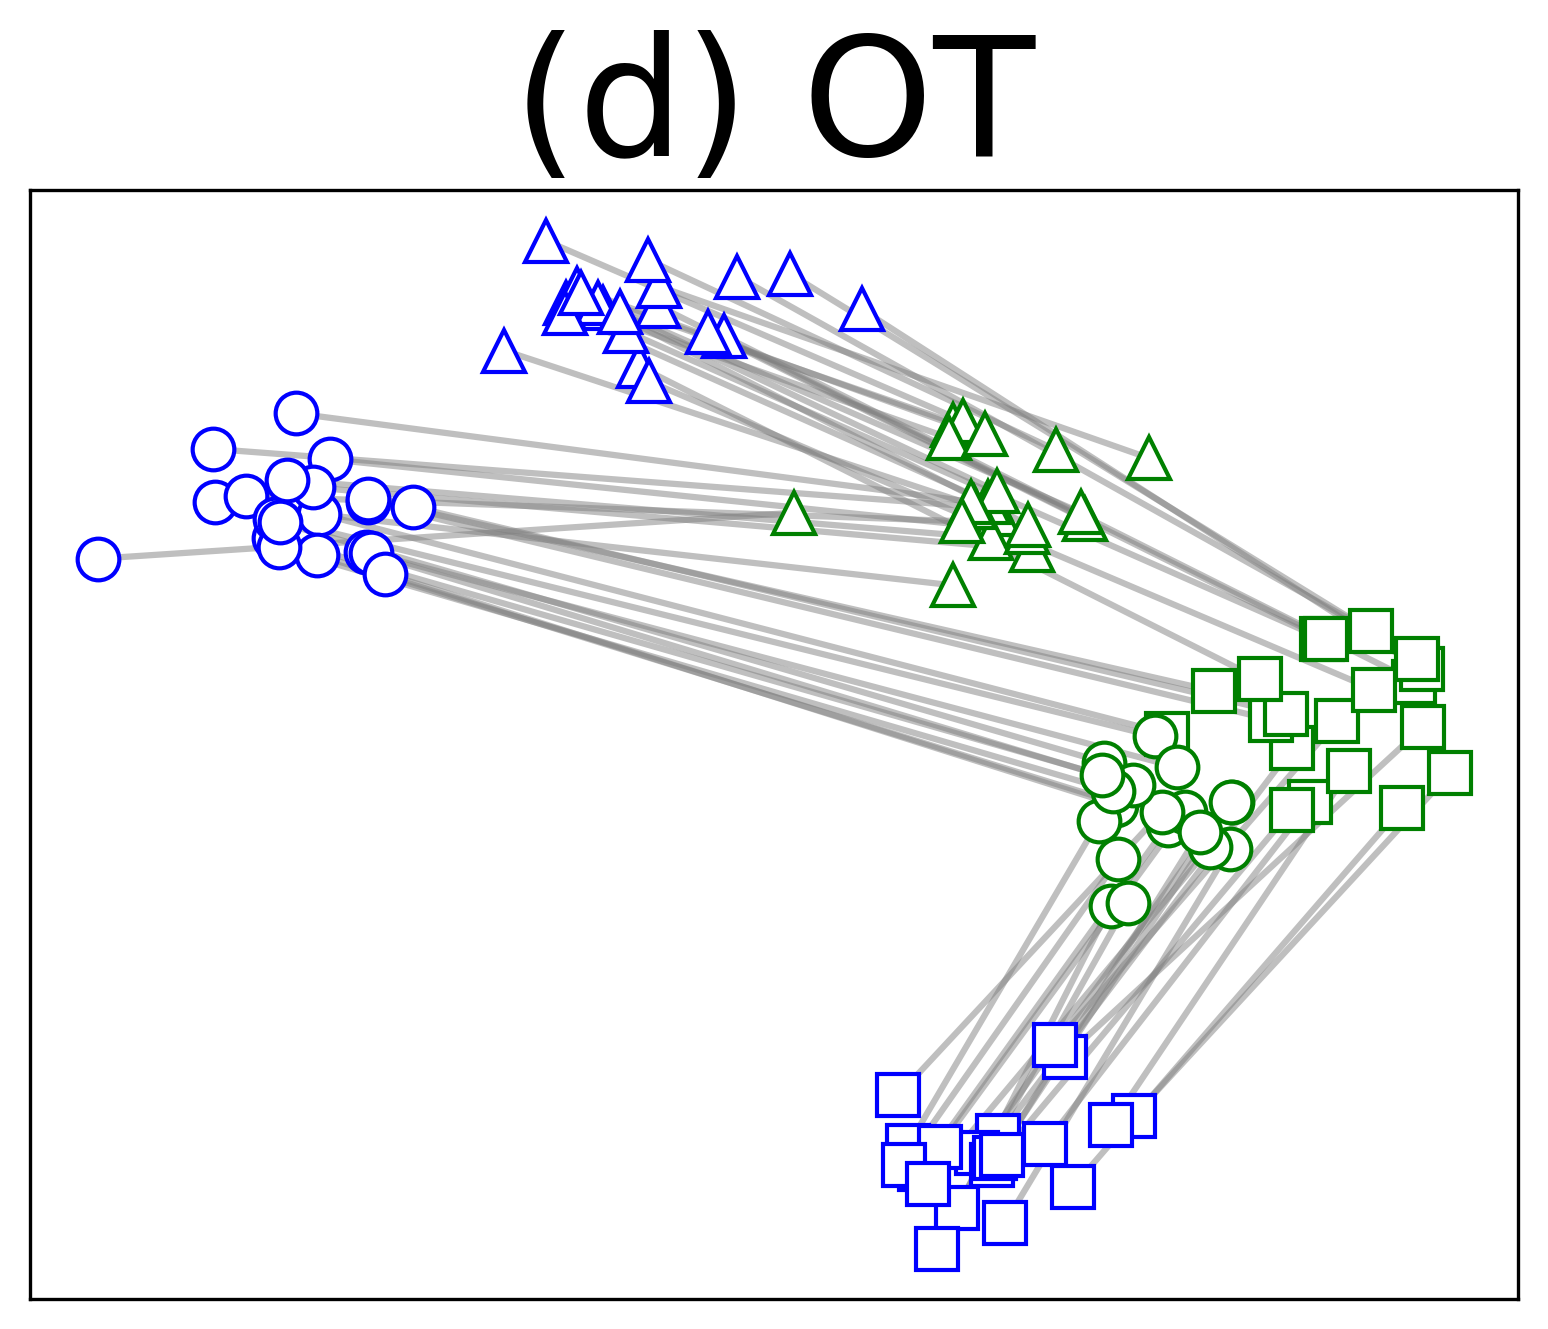

In [106]:
# EMD
np.random.seed(1)
model: EMD = models["OT"]
model.fit(X, Y, a, b)

# plot transport plan
ot.plot.plot2D_samples_mat(X, Y, model.P_, c="grey", alpha=0.5)

# plot data
for i in range(3):
    plt.plot(source[i][:,0], source[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
    plt.plot(target[i][:,0], target[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")

# compute accuracy
P = model.P_
labels = [0]*samples_per_cluster + [1]*samples_per_cluster + [2]*samples_per_cluster
labels = np.array(labels)
pred = np.argmax(P, axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
#plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100), fontsize=22)

plt.tick_params(
    axis='both',       # Apply to both x and y axes
    which='both',      # Apply to both major and minor ticks
    bottom=False,      # Turn off ticks on the bottom
    top=False,         # Turn off ticks on the top
    left=False,        # Turn off ticks on the left
    right=False,       # Turn off ticks on the right
    labelbottom=False, # Turn off labels on the bottom
    labelleft=False    # Turn off labels on the left
)
plt.title(fr"(d) OT", fontsize=40)
plt.show()